In [1]:
# Import necessary libraries
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Login to wandb (if not already logged in)
wandb.login()

# Define the project and entity
project_name = "Negatives"
entity_name = "ntourne"

# Initialize the wandb API
api = wandb.Api()

# Fetch all runs from the project
runs = api.runs(f"{entity_name}/{project_name}")

wandb: Currently logged in as: ntourne to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
# Initialize a list to store results
results = []

# Iterate through runs and extract metrics
for run in runs:
    # Get the summary metrics, config, and name of the run
    summary = run.summary._json_dict
    config = run.config
    name = run.name
    
    # Combine the data into a single dictionary
    run_data = {
        "run_name": name,
        "TF": config.get("TF"),
        "celltype": config.get("celltype"),
        "neg_mode": config.get("neg_mode"),
        "cross_val_set": config.get("cross_val_set"),
        "group_name": config.get("group_name"),
        "AUROC": summary.get("best_AUROC"),
        "AUROC_HQ": summary.get("best_AUROC_HQ"),
        "Accuracy": summary.get("best_Accuracy"),
        "Accuracy_HQ": summary.get("best_Accuracy_HQ"),
        "val_loss": summary.get("val_loss"),
    }
    results.append(run_data)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

In [3]:
results_df = results_df[results_df['group_name'] == "prelim_run_2"] # Only get prelim_run_1

In [4]:
# Filter out entries where AUROC_HQ == 0 -> probably an issue with the cross val split 
filtered_out_count = results_df[(results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna())].shape[0]

# Filter the DataFrame to exclude these entries
results_df = results_df[~((results_df['AUROC_HQ'] == 0) | (results_df['AUROC_HQ'].isna()))]

# Print the count of filtered-out entries
print(f"Number of entries where AUROC_HQ == 0: {filtered_out_count}")

Number of entries where AUROC_HQ == 0: 89


In [5]:
results_df["TF"].value_counts()

TF
ZBTB33                 24
CTCF                   24
Egr-1                  24
MAZ_(ab85725)          24
MafK_(ab50322)         24
MafF_(M8194)           24
Max                    24
YY1_(SC-281)           24
TBP                    24
JunD                   24
ATF1_(06-325)          24
SRF                    24
USF-1                  24
NF-YB                  24
SP1                    24
NF-YA                  24
Znf143_(16618-1-AP)    24
CEBPB_(SC-150)         24
TEAD4_(SC-101184)      24
ELF1_(SC-631)          24
Nrf1                   24
Mxi1_(AF4185)          24
STAT5A_(SC-74442)      24
FOSL1_(SC-183)         24
ZBTB7A_(SC-34508)      24
ETS1                   24
NR2F2_(SC-271940)      24
ATF3                   16
SIX5                   16
RFX5_(200-401-194)     16
MEF2A                  16
ELK1_(1277-1)          16
USF2                   16
Bach1_(sc-14700)       16
SETDB1                  8
ZNF274                  7
Name: count, dtype: int64

In [6]:
# Filter out TFs with less than 24 samples
results_df = results_df.groupby('TF').filter(lambda x: len(x) >= 24)

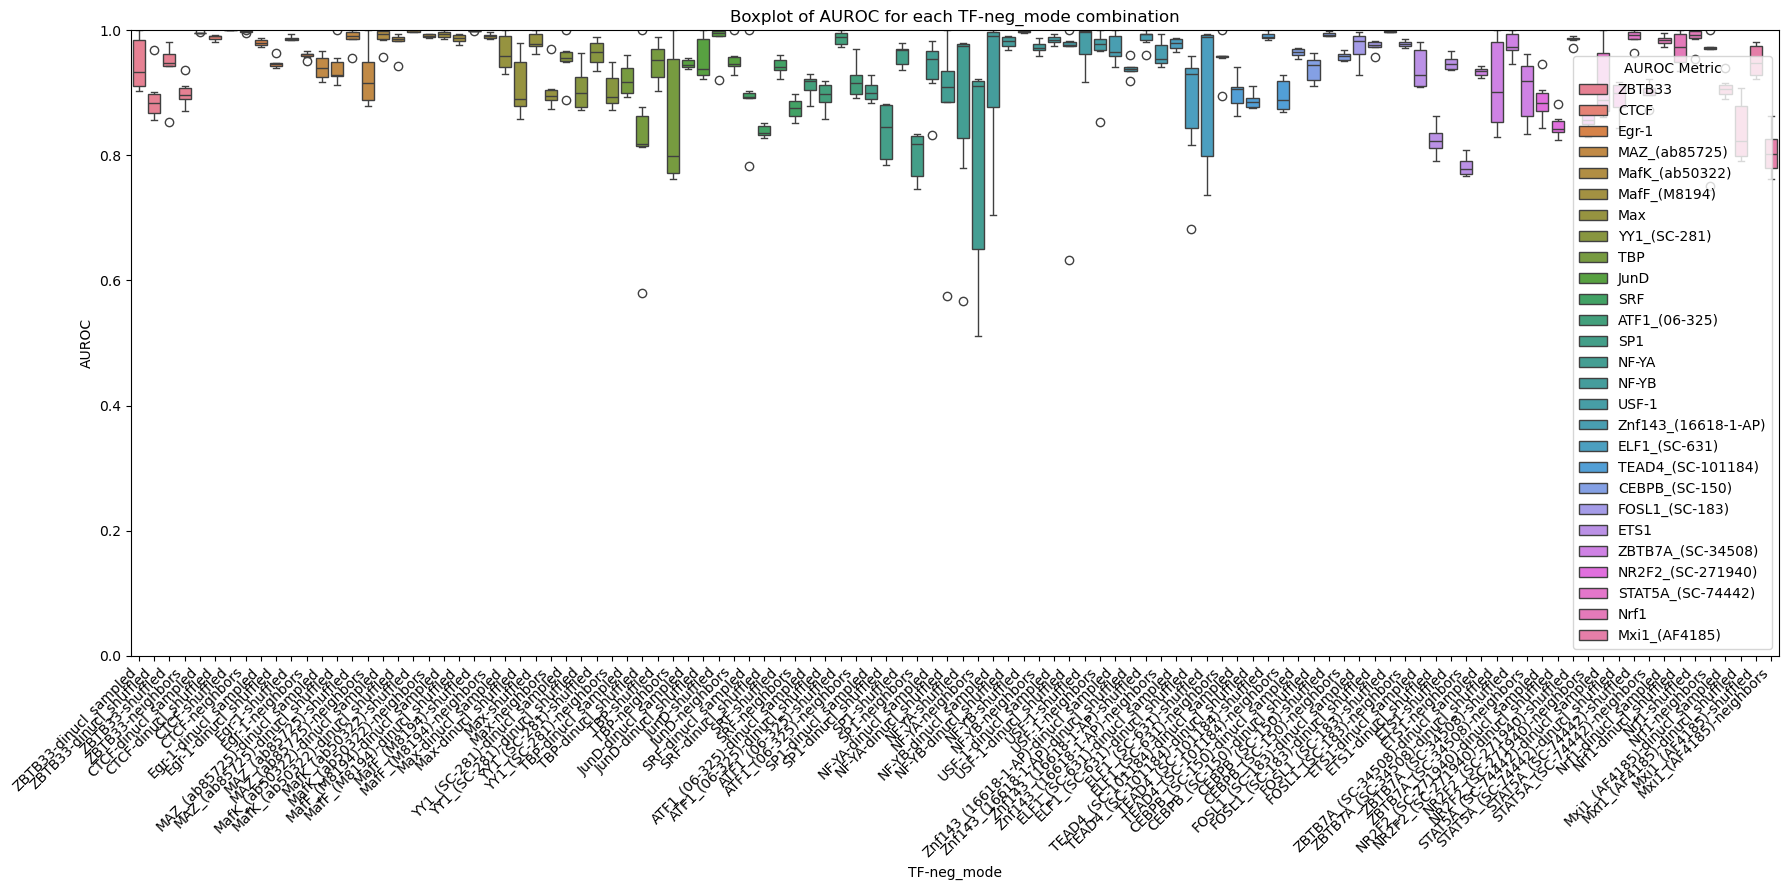

In [7]:
import seaborn as sns
# Create a new column combining TF and neg_mode
results_df['TF-neg_mode'] = results_df['TF'] + '-' + results_df['neg_mode']
results_df.sort_values(by=['TF', 'TF-neg_mode'])

# Create the boxplot
plt.figure(figsize=(18, 9))
sns.boxplot(data=results_df, x='TF-neg_mode', y='AUROC', hue="TF")
plt.xticks(rotation=45, ha='right')
plt.title('Boxplot of AUROC for each TF-neg_mode combination')
plt.legend(title='AUROC Metric', loc='lower right')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC')
plt.ylim(0,1)
plt.tight_layout()
plt.show()

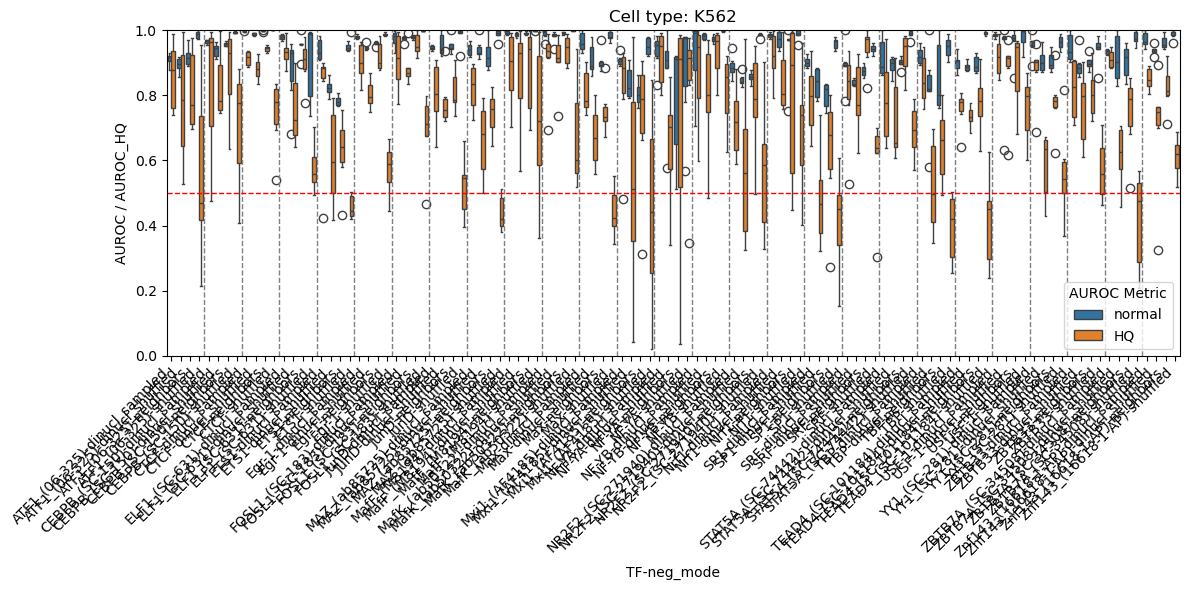

In [8]:
# Create the boxplot for AUROC
plt.figure(figsize=(12, 6))

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df.sort_values(by=['TF', 'TF-neg_mode']),
    id_vars=['TF-neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})


# Create the boxplot
sns.boxplot(data=melted_df, x='TF-neg_mode', y='AUROC_value', hue='auroc_metric')

# Add vertical lines between groups of the same TF
unique_tf_neg_modes = results_df.sort_values(by=['TF', 'TF-neg_mode'])['TF-neg_mode'].unique()
tf_groups = ['-'.join(tf.split('-')[:-1]) for tf in unique_tf_neg_modes]
group_changes = [i for i in range(1, len(tf_groups)) if tf_groups[i] != tf_groups[i - 1]]

for change in group_changes:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

# Add a horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='AUROC Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Cell type: K562')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


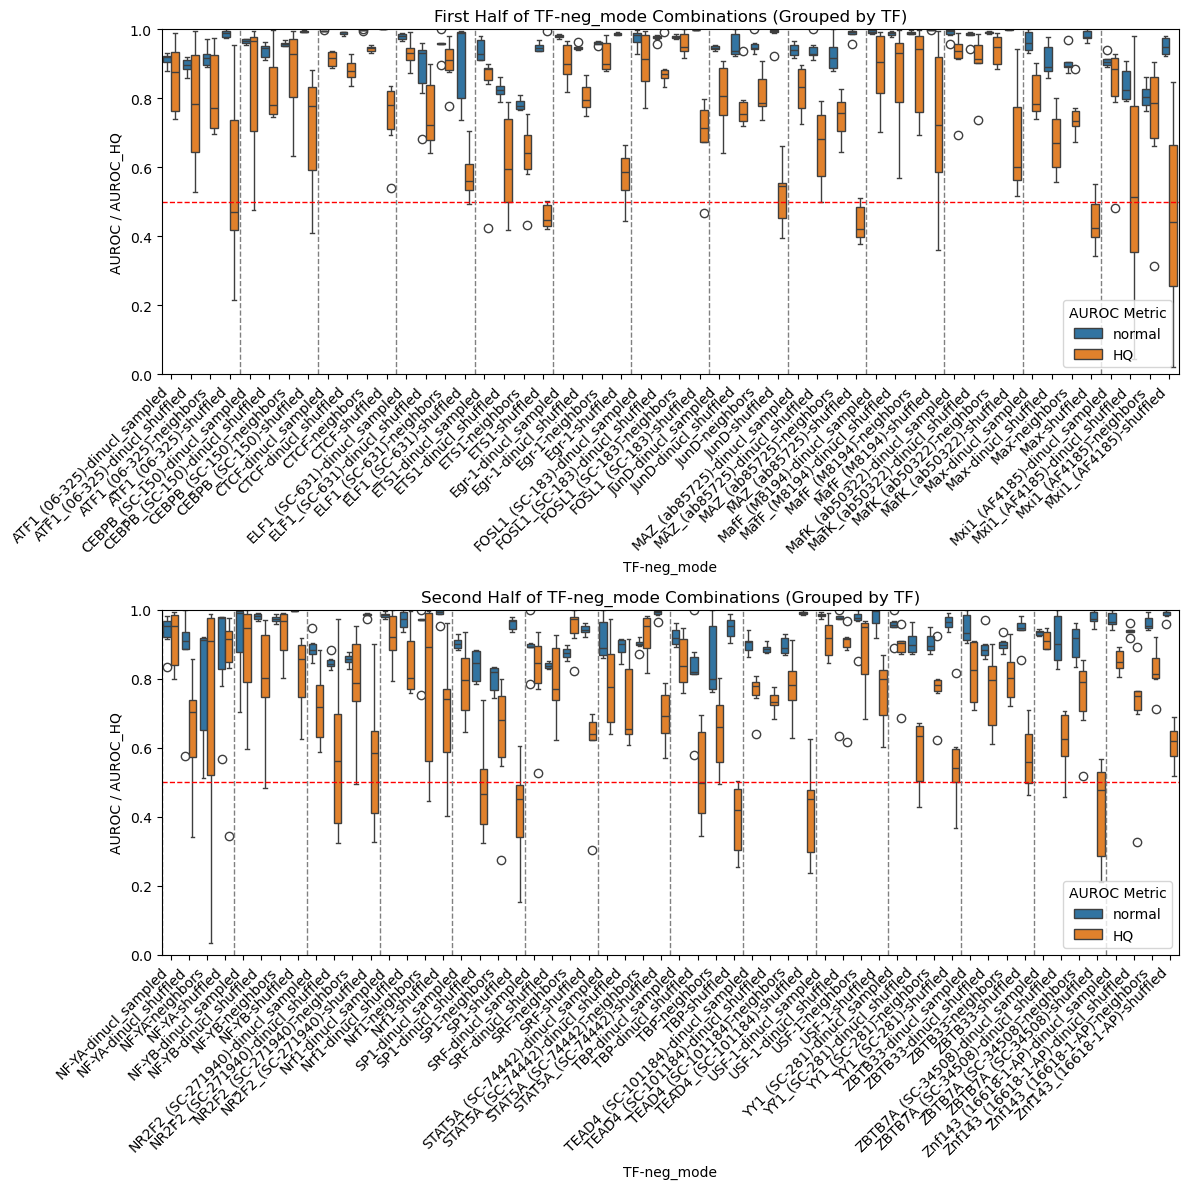

In [9]:
# Group the unique TF-neg_mode combinations by their TFs
tf_groups = {}
for tf_neg in unique_tf_neg_modes:
    tf = '-'.join(tf_neg.split('-')[:-1])  # Extract the TF part
    if tf not in tf_groups:
        tf_groups[tf] = []
    tf_groups[tf].append(tf_neg)

# Split the TF groups into two parts
tf_group_keys = list(tf_groups.keys())
mid_index = len(tf_group_keys) // 2
first_half_tfs = tf_group_keys[:mid_index]
second_half_tfs = tf_group_keys[mid_index:]

# Flatten the TF-neg_mode combinations for each part
first_half = [tf_neg for tf in first_half_tfs for tf_neg in tf_groups[tf]]
second_half = [tf_neg for tf in second_half_tfs for tf_neg in tf_groups[tf]]

# Create the first subplot
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
sns.boxplot(
    data=melted_df[melted_df['TF-neg_mode'].isin(first_half)],
    x='TF-neg_mode',
    y='AUROC_value',
    hue='auroc_metric'
)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.title('First Half of TF-neg_mode Combinations (Grouped by TF)')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.legend(title='AUROC Metric', loc='lower right')

# Add vertical lines between groups of the same TF
first_half_indices = [i for i in group_changes if i < len(first_half)]
for change in first_half_indices:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

# Create the second subplot
plt.subplot(2, 1, 2)
sns.boxplot(
    data=melted_df[melted_df['TF-neg_mode'].isin(second_half)],
    x='TF-neg_mode',
    y='AUROC_value',
    hue='auroc_metric'
)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=45, ha='right')
plt.title('Second Half of TF-neg_mode Combinations (Grouped by TF)')
plt.xlabel('TF-neg_mode')
plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.legend(title='AUROC Metric', loc='lower right')

# Add vertical lines between groups of the same TF
second_half_indices = [i - len(first_half) for i in group_changes if i >= len(first_half)]
for change in second_half_indices:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


In [10]:
results_df["AUROC_delta"] = results_df["AUROC"] - results_df["AUROC_HQ"]

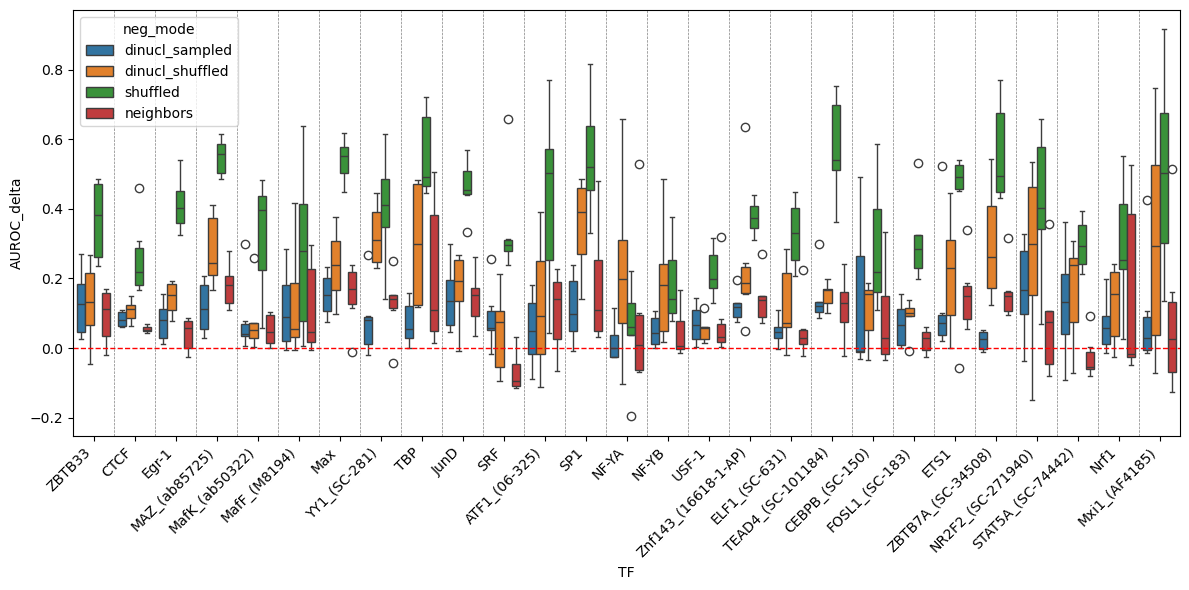

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Draw the boxplot
ax = sns.boxplot(data=results_df, x='TF', y='AUROC_delta', hue="neg_mode")

# Add horizontal reference line
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Get x-axis tick locations and add vertical lines between groups
xticks = ax.get_xticks()
for i in range(1, len(xticks)):
    xpos = (xticks[i - 1] + xticks[i]) / 2
    plt.axvline(x=xpos, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


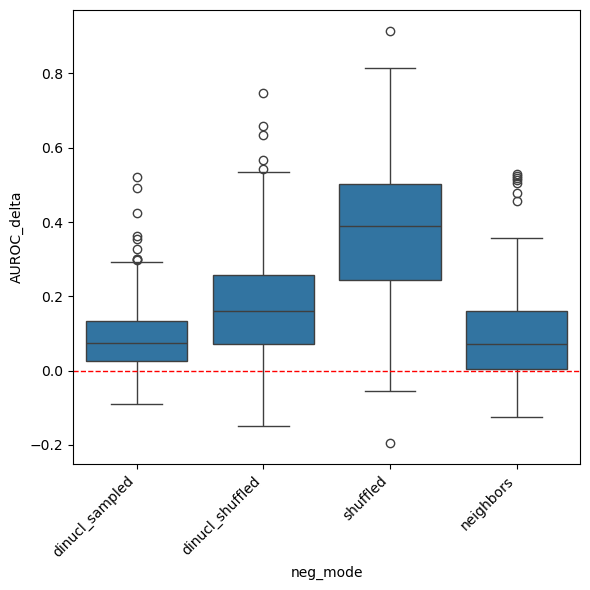

In [12]:
plt.figure(figsize=(6, 6))
# Create the boxplot
sns.boxplot(data=results_df, x='neg_mode', y='AUROC_delta')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

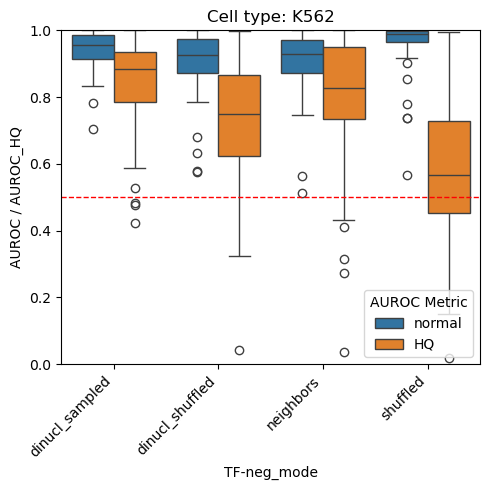

In [13]:
# Create the boxplot for AUROC
plt.figure(figsize=(5, 5))

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df.sort_values(by=['TF-neg_mode']),
    id_vars=['neg_mode'],
    value_vars=['AUROC', 'AUROC_HQ'],
    var_name='auroc_metric',
    value_name='AUROC_value'
)

# Map the metric names to more descriptive labels
melted_df['auroc_metric'] = melted_df['auroc_metric'].map({'AUROC': 'normal', 'AUROC_HQ': 'HQ'})


# Create the boxplot
sns.boxplot(data=melted_df, x='neg_mode', y='AUROC_value', hue='auroc_metric')



# Add a horizontal line at y=0.5
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Adjust legend
plt.legend(title='AUROC Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Cell type: K562')
plt.xlabel('TF-neg_mode')

plt.ylabel('AUROC / AUROC_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


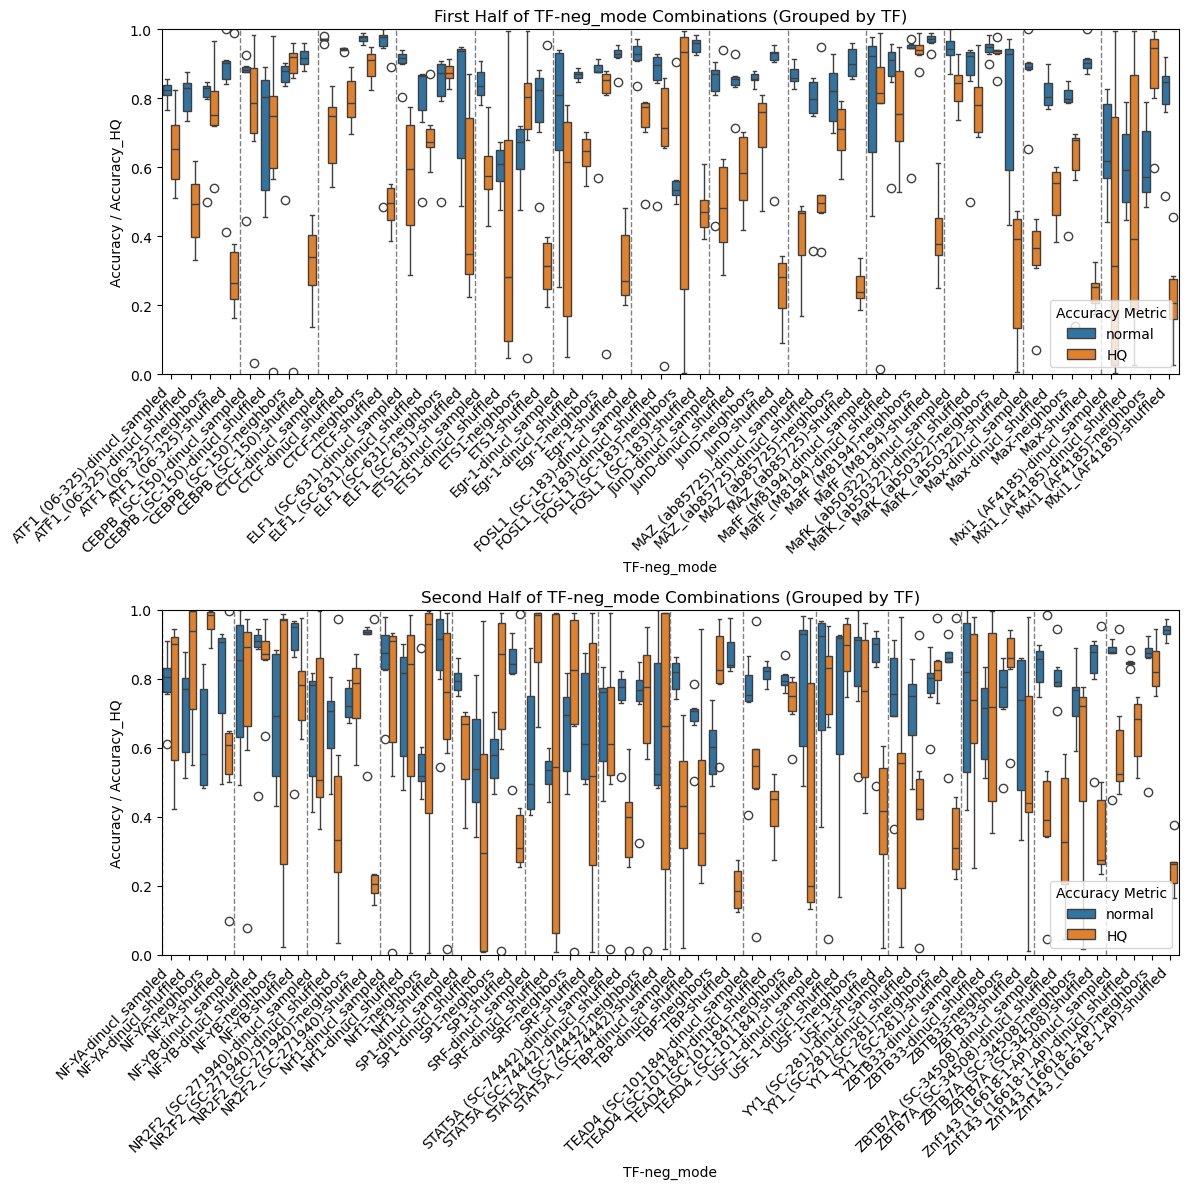

In [14]:

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df.sort_values(by=['TF', 'TF-neg_mode']),
    id_vars=['TF-neg_mode'],
    value_vars=['Accuracy', 'Accuracy_HQ'],
    var_name='Accuracy_metric',
    value_name='Accuracy_value'
)

# Map the metric names to more descriptive labels
melted_df['Accuracy_metric'] = melted_df['Accuracy_metric'].map({'Accuracy': 'normal', 'Accuracy_HQ': 'HQ'})


# Add vertical lines between groups of the same TF
unique_tf_neg_modes = results_df.sort_values(by=['TF', 'TF-neg_mode'])['TF-neg_mode'].unique()
tf_groups = ['-'.join(tf.split('-')[:-1]) for tf in unique_tf_neg_modes]
group_changes = [i for i in range(1, len(tf_groups)) if tf_groups[i] != tf_groups[i - 1]]

tf_groups = {}
for tf_neg in unique_tf_neg_modes:
    tf = '-'.join(tf_neg.split('-')[:-1])  # Extract the TF part
    if tf not in tf_groups:
        tf_groups[tf] = []
    tf_groups[tf].append(tf_neg)

# Split the TF groups into two parts
tf_group_keys = list(tf_groups.keys())
mid_index = len(tf_group_keys) // 2
first_half_tfs = tf_group_keys[:mid_index]
second_half_tfs = tf_group_keys[mid_index:]

# Flatten the TF-neg_mode combinations for each part
first_half = [tf_neg for tf in first_half_tfs for tf_neg in tf_groups[tf]]
second_half = [tf_neg for tf in second_half_tfs for tf_neg in tf_groups[tf]]

# Create the first subplot
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
sns.boxplot(
    data=melted_df[melted_df['TF-neg_mode'].isin(first_half)],
    x='TF-neg_mode',
    y='Accuracy_value',
    hue='Accuracy_metric'
)

plt.xticks(rotation=45, ha='right')
plt.title('First Half of TF-neg_mode Combinations (Grouped by TF)')
plt.xlabel('TF-neg_mode')
plt.ylabel('Accuracy / Accuracy_HQ')
plt.ylim(0, 1)
plt.legend(title='Accuracy Metric', loc='lower right')

# Add vertical lines between groups of the same TF
first_half_indices = [i for i in group_changes if i < len(first_half)]
for change in first_half_indices:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

# Create the second subplot
plt.subplot(2, 1, 2)
sns.boxplot(
    data=melted_df[melted_df['TF-neg_mode'].isin(second_half)],
    x='TF-neg_mode',
    y='Accuracy_value',
    hue='Accuracy_metric'
)

plt.xticks(rotation=45, ha='right')
plt.title('Second Half of TF-neg_mode Combinations (Grouped by TF)')
plt.xlabel('TF-neg_mode')
plt.ylabel('Accuracy / Accuracy_HQ')
plt.ylim(0, 1)
plt.legend(title='Accuracy Metric', loc='lower right')

# Add vertical lines between groups of the same TF
second_half_indices = [i - len(first_half) for i in group_changes if i >= len(first_half)]
for change in second_half_indices:
    plt.axvline(change - 0.5, color='gray', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()


In [15]:
results_df["Accuracy_delta"] = results_df["Accuracy"] - results_df["Accuracy_HQ"]

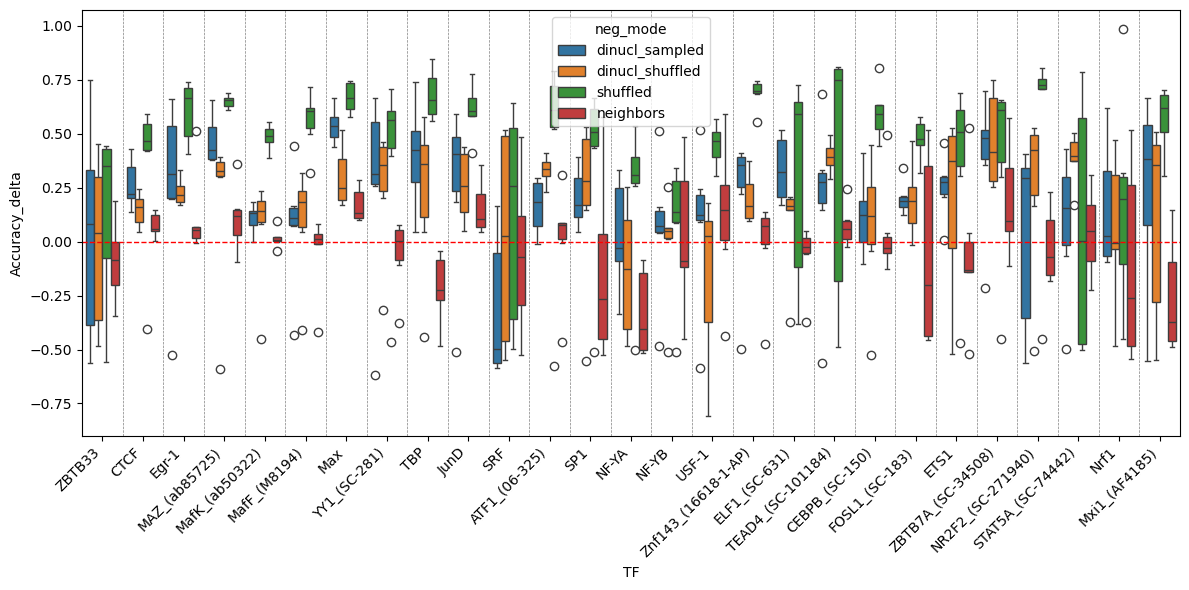

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Draw the boxplot
ax = sns.boxplot(data=results_df, x='TF', y='Accuracy_delta', hue="neg_mode")

# Add horizontal reference line
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Get x-axis tick locations and add vertical lines between groups
xticks = ax.get_xticks()
for i in range(1, len(xticks)):
    xpos = (xticks[i - 1] + xticks[i]) / 2
    plt.axvline(x=xpos, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


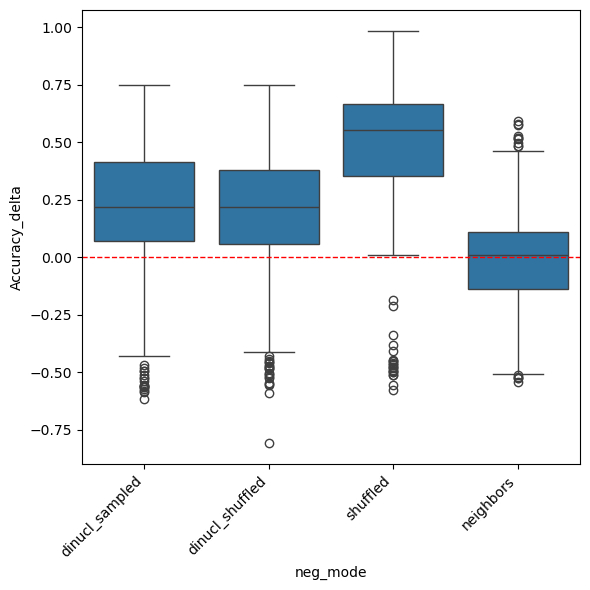

In [17]:
plt.figure(figsize=(6, 6))
# Create the boxplot
sns.boxplot(data=results_df, x='neg_mode', y='Accuracy_delta')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

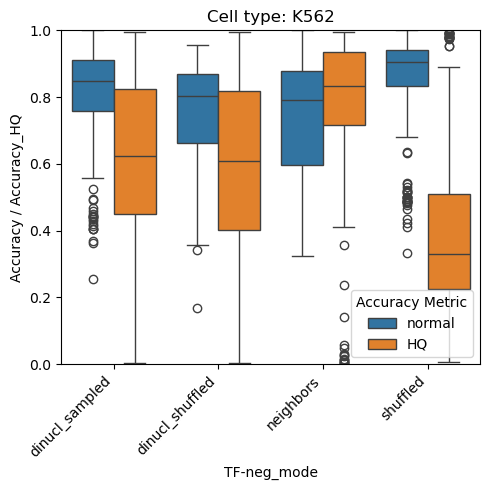

In [18]:
# Create the boxplot for AUROC
plt.figure(figsize=(5, 5))

# Create a new DataFrame with AUROC and AUROC_HQ combined into a single column
melted_df = pd.melt(
    results_df.sort_values(by=['TF-neg_mode']),
    id_vars=['neg_mode'],
    value_vars=['Accuracy', 'Accuracy_HQ'],
    var_name='Accuracy_metric',
    value_name='Accuracy_value'
)

# Map the metric names to more descriptive labels
melted_df['Accuracy_metric'] = melted_df['Accuracy_metric'].map({'Accuracy': 'normal', 'Accuracy_HQ': 'HQ'})


# Create the boxplot
sns.boxplot(data=melted_df, x='neg_mode', y='Accuracy_value', hue='Accuracy_metric')

# Adjust legend
plt.legend(title='Accuracy Metric', loc='lower right')

# Adjust plot aesthetics
plt.xticks(rotation=45, ha='right')
plt.title('Cell type: K562')
plt.xlabel('TF-neg_mode')

plt.ylabel('Accuracy / Accuracy_HQ')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
